In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.preprocessing.sequence import  pad_sequences
from keras.datasets import imdb

from konlpy.tag import Okt
import statsmodels.api as sm
%matplotlib inline

Using TensorFlow backend.


# RNN 

In [9]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10)))   #   input_lengtg는 입력 시컨스의 길이
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일함.
model.summary()
# 크기는 hidden 갯수와 dim에 의해 결정됨
# wx = 3 *  10  = 30      입력에서 hidden으로   
# wh = 3 * 3    = 9       출력이 hidden*hidden이므로   
# b = 3         = 3              -> 42개   # 출력층의 hidden

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


# RNN을 이용한 시계열 데이터 분석 예

In [10]:
step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]   # 800, 200개로 분할

print(train.shape)
print(test.shape)

(800, 1)
(200, 1)


In [11]:
seq = [1,2,3,4,5,6,7]
sp = 3

seq = [1,2,3,4,5,6,7,7,7,7]
#  3개의 seq 길이를 갖도록 학습 데이터 seq 생성
#  1,2,3,4,5,6,7,7,7,7                 [1,2,3]       [4]  입력값과 출력값
#                                      [2,3,4]       [5]   
#                                      [3,4,5]       [6]   
#                                      [4,5,6]       [7] 
#                                      [5,6,7]       [7] 
#                                      [6,7,7]       [7] 
#                                      [7,7,7]       [7] 
#sliding은 지원하지 않아서 직접 코딩해야 해. 아래처럼.

In [12]:
#뒤에 padding
train = np.append(train,np.repeat(train[-1,],step))  # 마지막값을 step만큼 반복
test = np.append(test,np.repeat(test[-1,],step))

In [13]:
print(train.shape)
print(test.shape)

(804,)
(204,)


In [14]:
print(train[:10])
print(train[798:])

[1.47766072 0.29680391 1.20864223 1.06904102 1.59200957 2.03280435
 1.42407428 1.83310514 1.92341997 1.73066841]
[-0.13559543  1.50641673  1.50641673  1.50641673  1.50641673  1.50641673]


In [15]:
#input:[1,2,3], output:[4]

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

print(trainX.shape)
print(trainY.shape)

(800, 4)
(800,)


In [16]:
print(train[:10])
print(trainX[0])
print(trainX[1])
print(trainY[0])
print(trainY[1])

[1.47766072 0.29680391 1.20864223 1.06904102 1.59200957 2.03280435
 1.42407428 1.83310514 1.92341997 1.73066841]
[1.47766072 0.29680391 1.20864223 1.06904102]
[0.29680391 1.20864223 1.06904102 1.59200957]
1.5920095707834974
2.0328043459112757


In [17]:
#3차원 shape으로 구성
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(800, 1, 4)


In [18]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="tanh")) #units:은닉층의 벡터dimension=32
model.add(Dense(8, activation="tanh")) 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=0)

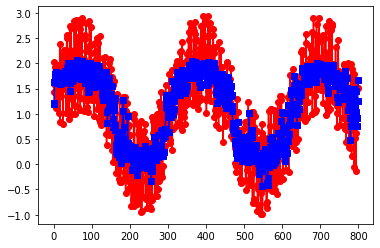

In [19]:
plt.plot(trainY, 'ro-', label="target")
plt.plot(model.predict(trainX), 'bs-', label="output")

(-3, 3)

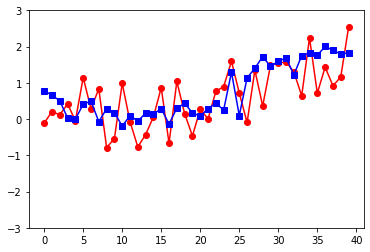

In [20]:
#데이터를 줄인 것. 5번씩 건너뛰면서.
plt.plot(testY[0::5], 'ro-', label="target")
plt.plot(model.predict(testX[0::5]), 'bs-', label="output") #0부터 끝까지 5씩 증가
plt.ylim([-3,3])

 # "영국의 호흡기 질환으로 인한 사망자 수" 시계열 데이터분석

In [21]:
data = sm.datasets.get_rdataset("deaths", "MASS")
df = data.data
df.tail()

,time,value
67,1979.583333,1354
68,1979.666667,1333
69,1979.750000,1492
70,1979.833333,1781
71,1979.916667,1915


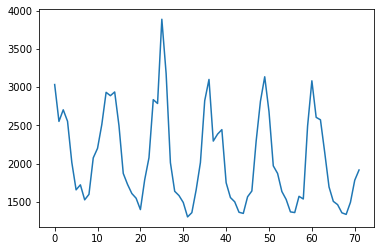

In [22]:
df.value.plot()
plt.show()

In [23]:
df["cliped_value"] = df.value.clip_upper(2000)
df.cliped_value.plot()
plt.show()

AttributeError: 'Series' object has no attribute 'clip_upper'

In [24]:
print(df.cliped_value)
print(df.cliped_value.values)

AttributeError: 'DataFrame' object has no attribute 'cliped_value'

In [27]:
seq = [1,2,3,4,5,6,7]
ts = 3;

#  3개의 seq 길이를 갖도록 학습 데이터 생성,   y값은 ts 다음값(즉 4번째 부터 가져옴)
#  1,2,3,4,5,6,7,8,9                   [1,2,3]      [4] 
#                                      [2,3,4]     [5]      
x = np.array([np.array([seq[i+j] for j in range(ts)])  
                      for i in range(len(seq) - ts)]).reshape(-1,ts,1)   
y = seq[ts:]

print(x.shape)
print(x)
print(y)

(4, 3, 1)
[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]]
[4, 5, 6, 7]


In [28]:
ts = 7

df["cliped_std_value"] = df.cliped_value.map(lambda x : (x - df.cliped_value.mean()) / np.std(df.cliped_value))
#df["cliped_std_value"] = df.cliped_value
X_train = np.array([np.array([df.cliped_std_value.values[i+j] for j in range(ts)])  # ts만큼 만복
                      for i in range(len(df.cliped_std_value) - ts)]).reshape(-1,ts,1)
y_train = df.cliped_std_value.values[ts:]
print(X_train.shape)
print(y_train.shape)

(65, 7, 1)
(65,)


In [29]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, input_shape=(ts, 1)))
model_RNN.add(Dense(1, activation="linear"))
model_RNN.compile(loss='mse', optimizer='adam')

In [30]:
history_RNN = model_RNN.fit(X_train, y_train, epochs=1000,verbose=0)

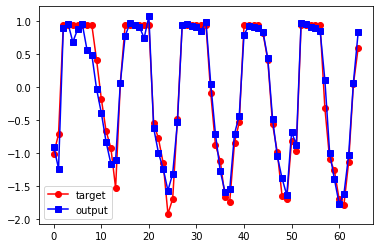

In [33]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model_RNN.predict(X_train), 'bs-', label="output")
plt.legend()
plt.show()

In [34]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(ts, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000,verbose=0)


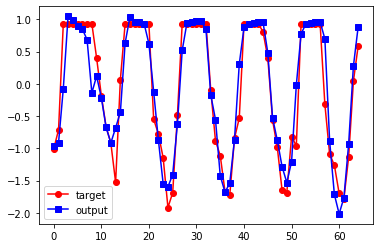

In [35]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train), 'bs-', label="output")
plt.legend()
plt.show()

# 문장 분석(imdb)

In [151]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32 

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [152]:
print(len(x_train[0]))
print(x_train[0])
print(len(x_train[1]))
print(x_train[1])

218
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
189
[1, 194, 1153, 194, 8255, 78, 228, 5, 6,

In [154]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [156]:
print(x_train[0])
print(x_train[1])

[   15   256     4     2     7  3766     5   723    36    71    43   530
   476    26   400   317    46     7     4 12118  1029    13   104    88
     4   381    15   297    98    32  2071    56    26   141     6   194
  7486    18     4   226    22    21   134   476    26   480     5   144
    30  5535    18    51    36    28   224    92    25   104     4   226
    65    16    38  1334    88    12    16   283     5    16  4472   113
   103    32    15    16  5345    19   178    32]
[ 125   68    2 6853   15  349  165 4362   98    5    4  228    9   43
    2 1157   15  299  120    5  120  174   11  220  175  136   50    9
 4373  228 8255    5    2  656  245 2350    5    4 9837  131  152  491
   18    2   32 7464 1212   14    9    6  371   78   22  625   64 1382
    9    8  168  145   23    4 1690   15   16    4 1355    5   28    6
   52  154  462   33   89   78  285   16  145   95]


In [157]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [158]:
%%time
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2, #15
          validation_data=(x_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 109s 4ms/step - loss: 0.4292 - accuracy: 0.7968 - val_loss: 0.3567 - val_accuracy: 0.8427
Epoch 2/2
25000/25000 [==============================] - 107s 4ms/step - loss: 0.2526 - accuracy: 0.9000 - val_loss: 0.4002 - val_accuracy: 0.8204
Wall time: 3min 37s


In [159]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 21s 836us/step
Test score: 0.4001913144683838
Test accuracy: 0.8204399943351746


# 네이버

In [25]:
train_data= pd.read_table('./nlp/ratings_train.txt')
test_data= pd.read_table('./nlp/ratings_test.txt')

train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글이 아닌 걸 빈문자로.
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #불필요한 데이터들

In [26]:
#형태소 분석
okt = Okt()
X_train=[]
for sentence in train_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [27]:

test_data=test_data.dropna(how='any') # Null 값 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

X_test=[]
for sentence in test_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [28]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) #imdb같은 형태
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
#word embedding
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [30]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=2, batch_size=60, validation_split=0.2)  # 1번 2분  84% -> 85%

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 119996 samples, validate on 29999 samples
Epoch 1/2
 90900/119996 [=====================>........] - ETA: 31s - loss: 0.3995 - accuracy: 0.8156

In [ ]:
# 9:48
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
model.evaluate(x_test, y_test)